<a href="https://colab.research.google.com/github/vincentjunitio00/FUTURE-Project-1/blob/main/%5BBlibli_Future_Data_Track%5D%20Unsupervised%20Learning%20-%20Flash%20sale%20time%20range%20recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Frame the problem

Objective: to create an unsupervised learning model (recommendation system) to recommend the flash sale time range recommendation.

# 2. Import data and library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

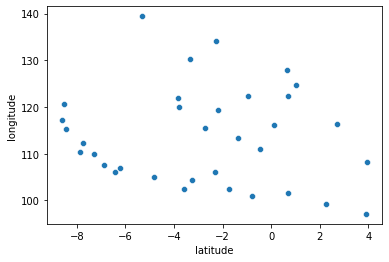

In [2]:
df_real = pd.read_csv('https://raw.githubusercontent.com/vincentjunitio00/FUTURE-Project-1/main/bq2.csv')

# Load another data 'Customer_state_geo.csv' to get the longitude and latitude of states in Indonesia
geo = pd.read_csv('https://raw.githubusercontent.com/vincentjunitio00/FUTURE-Project-1/main/Customer_state_geo.csv')
geo.columns = ['state', 'latitude', 'longitude']
df_real['product_category'] = df_real['product_category'].fillna('others')

sns.scatterplot(x = 'latitude', y = 'longitude', data = geo)
plt.show()

Take a quick look on the table.

In [3]:
df_real.head()

,price,shipping_cost,full_time,hour,minute,second,is_morning,is_noon,is_afternoon,is_night,seller_city,seller_state,customer_city,customer_state,product_category
0,239900.0,19930.0,10:53:06,10,53,6,f,t,f,f,KOTA TANGERANG,BANTEN,KABUPATEN MALAKA,NUSA TENGGARA TIMUR,pet_shop
1,45000.0,12980.0,17:21:27,17,21,27,f,f,t,f,KOTA TANGERANG,BANTEN,KABUPATEN KARAWANG,JAWA BARAT,fashion_bags_accessories
2,639000.0,11340.0,09:10:41,9,10,41,t,f,f,f,KOTA TANGERANG SELATAN,BANTEN,KOTA JAKARTA TIMUR,DKI JAKARTA,consoles_games
3,21990.0,11850.0,18:54:23,18,54,23,f,f,f,t,KOTA TANGERANG,BANTEN,KABUPATEN PIDIE,ACEH,telephony
4,119990.0,44400.0,10:33:13,10,33,13,f,t,f,f,KABUPATEN JOMBANG,JAWA TIMUR,KABUPATEN SUKOHARJO,JAWA TENGAH,office_furniture


# 3. Feature selection

In [4]:
columns = ['price', 'hour', 'customer_state', 'product_category']
df = df_real[columns].copy()

In [5]:
def check_products(df):
  """ To return the product categories.
  Parameters:
  df: the dataframe

  Return:
  The list of product categories
  """
  return np.unique(df['product_category'].tolist())

In [6]:
def check_state(product_category):
  """ To return the customer states in which the product category has been sold.
  Paremeters:
  product_category: the product category

  Return:
  The list of customer states
  """
  return np.unique(df[df['product_category'] == product_category]['customer_state'].tolist())

In [7]:
list_of_products = check_products(df)

# 4. Model training

# 4.1 First Model

The first model only considers the product_category. It loops through each product_category and get its top hour in which that product_category has been sold. The final score for the first recommendation model is the number of items sold on that hour divide by the total number of items sold on that product category.

In [8]:
def first_recommender(df):
  """ To train the first recommendation model.
  Parameters:
  df: the dataframe 

  Return:
  The model score
  """
  metrics = []
  for product_category in list_of_products:
    total_product_sales_count = len(df[(df['product_category'] == product_category)])

    history = df[(df['product_category'] == product_category)].sort_values('hour', ascending=True)
    history.hour = history.hour.astype('object')
    top = history.hour.value_counts(ascending=False).head(1).index.tolist()
    maximal = top[0]

    metric = len(history[(history['hour'] == maximal) & (history['product_category'] == product_category)]) / total_product_sales_count 
    metrics.append(metric)
  return np.mean(metrics)

first_result = first_recommender(df)
print("First recommender score:", first_result)

First recommender score: 0.11255083696307312


# 4.2 Second model

The second model considers the product_category and the customer_state. It loops through each product_category and find which states that product_category has been sold to. Next, it loops through each state and find its five nearest states. After that, get the hour in which that product_category has sold the most. Finally, count the number of items sold on that hour divide by the total number of items sold on that product category and that states. The score that represents the product_category is the mean of the score within the states looping. The final score for the second recommendation is the mean of all the score that represents the product_category.

In [9]:
def second_recommender(df):
  """ To train the second recommendation model.
  Parameters:
  df: the dataframe

  Return:
  The model score
  """
  metrics = []
  for product_category in list_of_products:
    states = check_state(product_category)
    metric_states = []
    for state in states:
      lat, long = geo[geo['state'] == state.upper()]['latitude'].values, geo[geo['state'] == state.upper()]['longitude'].values
      geo['distance_towards_state'] = np.sqrt((geo['latitude'] - lat) ** 2 + (geo['longitude'] - long) ** 2)
      records = geo.sort_values(by=['distance_towards_state'], ascending=True)
      chosen = records.head(5+1)['state'].values
    
      total_product_sales_count = len(df[(df['product_category'] == product_category) & (df['customer_state'].isin(chosen))])

      history = df[(df['customer_state'].isin(chosen)) & (df['product_category'] == product_category)].sort_values('hour', ascending=True)
      top = history.hour.value_counts(ascending=False).head(1).index.tolist()
      maximal = top[0]

      metric_states.append((len(history[(history['hour'] == maximal) & (history['product_category'] == product_category)]) / total_product_sales_count))
    mean_metric_states = np.mean(metric_states)
    metrics.append(mean_metric_states)
  return np.mean(metrics)

second_result = second_recommender(df)
print("Second recommender score:", second_result)

Second recommender score: 0.20414849066908175


# 4.3 Third model

The third recommendation considers the product_category and the price. The price is firstly normalized with log transformation. After the transformation, the normalized price is divided into several categories based on the minimum value, the first quartile, the second quartile (median), the third quartile, and the maximum value. Next, it loops through each product_category and also loops through each category of the normalized price. Then, get the hour in which that product_category has sold the most. Finally, count the number of items sold on that hour divide by the total number of items sold on that product category and that normalized price categories. The score that represents the product_category is the mean of the score within the normalized price categories looping. The final score for the third recommendation is the mean of all the score that represents the product_category.

In [10]:
def third_recommender(df):
  """ To train the third recommendation model.
  Parameters:
  df: the dataframe

  Return:
  The model score
  """
  metrics = []
  for product_category in list_of_products:
    df_category = df[df['product_category'] == product_category].copy()
    df_category['price_normalized'] = np.log(df_category['price'])
    quantiles = np.unique(df_category[df_category['product_category'] == product_category]['price_normalized'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist())
    df_category['price_cat'] = pd.cut(df_category[df_category['product_category'] == product_category]['price_normalized'], bins=np.insert(quantiles, 0, -1), labels=np.arange(len(quantiles)))
    cat_list = np.unique(df_category['price_cat'].tolist())
    metric_cat = []

    for cat in cat_list:
      total_product_sales_count = len(df_category[(df_category['product_category'] == product_category) & (df_category['price_cat'] == cat)])

      history = df_category[(df_category['product_category'] == product_category) & (df_category['price_cat'] == cat)].sort_values('hour', ascending=True)
      history.hour = history.hour.astype('object')
      top = history.hour.value_counts(ascending=False).head(1).index.tolist()
      maximal = top[0]

      metric = len(history[(history['hour'] == maximal) & (history['product_category'] == product_category)]) / total_product_sales_count
      metric_cat.append(metric)
    metrics.append(np.mean(metric_cat))
  return np.mean(metrics)

third_result = third_recommender(df)
print("Third recommender score:", third_result)

Third recommender score: 0.29674633777914117


# 5. Model evaluation

Since the third recommendation model has the greatest score, the third recommendation model is chosen to generate the time range recommendation.

# 6. Model recommendation

#6.1 The first model recommendation (not chosen)

In [11]:
def first_recommendation(df, product_category):
  """ To generate the time range recommendation with the first model
  Parameters:
  df: the dataframe
  product_category: the offered product_category

  Return:
  The time range recommendation
  """
  total_product_sales_count = len(df[(df['product_category'] == product_category)])

  history = df[(df['product_category'] == product_category)].sort_values('hour', ascending=True)
  history.hour = history.hour.astype('object')
  top = history.hour.value_counts(ascending=False).head(1).index.tolist()
  maximal = top[0]

  print("We highly recommend you to offer flash sale your {} products from {}:00 to {}:59 WIB.".format(product_category, maximal, maximal))

In [12]:
first_recommendation(df, 'pet_shop')

We highly recommend you to offer flash sale your pet_shop products from 14:00 to 14:59 WIB.


#6.2 The second model recommendation (not chosen)

In [13]:
def second_recommendation(df, product_category, customer_state):
  """ To generate the time range recommendation with the second model.
  Parameters:
  df: the dataframe
  product_category: the offered product_category
  customer_state: the customer_state to target on

  Return:
  The time range recommendation
  """
  lat, long = geo[geo['state'] == customer_state.upper()]['latitude'].values, geo[geo['state'] == customer_state.upper()]['longitude'].values
  geo['distance_towards_state'] = np.sqrt((geo['latitude'] - lat) ** 2 + (geo['longitude'] - long) ** 2)
  records = geo.sort_values(by=['distance_towards_state'], ascending=True)
  chosen = records.head(5+1)['state'].values

  total_product_sales_count = len(df[(df['product_category'] == product_category) & (df['customer_state'].isin(chosen))])

  history = df[(df['customer_state'].isin(chosen)) & (df['product_category'] == product_category)].sort_values('hour', ascending=True)
  top = history.hour.value_counts(ascending=False).head(1).index.tolist()
  maximal = top[0]

  print("We highly recommend you to offer flash sale your {} products from {}:00 to {}:59 WIB.".format(product_category, maximal, maximal))

In [14]:
second_recommendation(df, 'pet_shop', 'aceh')

We highly recommend you to offer flash sale your pet_shop products from 12:00 to 12:59 WIB.


In [15]:
second_recommendation(df, 'pet_shop', 'bali')

We highly recommend you to offer flash sale your pet_shop products from 13:00 to 13:59 WIB.


# 6.3 The third model recommendation (chosen)

In [16]:
def third_recommendation(df, product_category, price):
  """ To generate the time range recommendation with the third model.
  Parameters:
  df: the dataframe
  product_category: the offered product_category
  price: the offered price

  Return:
  The time range recommendation
  """
  df_category = df[df['product_category'] == product_category].copy()
  df_category['price_normalized'] = np.log(df_category['price'])
  quantiles = np.unique(df_category[df_category['product_category'] == product_category]['price_normalized'].quantile([0, 0.25, 0.5, 0.75, 1]).tolist())
  df_category['price_cat'] = pd.cut(df_category[df_category['product_category'] == product_category]['price_normalized'], bins=np.insert(quantiles, 0, -1), labels=np.arange(len(quantiles)))
  
  test_cat = 0
  categories = np.unique(df_category['price_cat'])
  for cat in categories:
    df_cat = df_category[df_category['price_cat'] == cat].copy()
    min = df_cat['price_normalized'].min()
    price_transformed = np.where(price > 0.0, np.log(price), 0)
    if price_transformed >= min:
      test_cat = cat

  total_product_sales_count = len(df_category[(df_category['product_category'] == product_category) & (df_category['price_cat'] == test_cat)])

  history = df_category[(df_category['product_category'] == product_category) & (df_category['price_cat'] == test_cat)].sort_values('hour', ascending=True)
  history.hour = history.hour.astype('object')
  top = history.hour.value_counts(ascending=False).head(1).index.tolist()
  maximal = top[0]

  print("We highly recommend you to offer flash sale your {} products from {}:00 to {}:59 WIB.".format(product_category, maximal, maximal))

In [17]:
third_recommendation(df, 'pet_shop', 1000)

We highly recommend you to offer flash sale your pet_shop products from 12:00 to 12:59 WIB.


In [18]:
third_recommendation(df, 'pet_shop', 12000)

We highly recommend you to offer flash sale your pet_shop products from 14:00 to 14:59 WIB.


# 7. Conclusion

Since the third recommendation model is chosen, the seller will be required to fill the product_category and the price in order to generate the time range recommendation to offer the flash sale.